# PREP

In [25]:
import warnings
warnings.filterwarnings("ignore")

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Verificar se GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    print("GPU is not in use. Please enable a GPU in Colab settings.")
print(f'Using device: {device}')

# Carregar o arquivo CSV
file_path = 'data_tp1'
data = pd.read_csv(file_path, header=None)

# Normalizar os dados de entrada (pixels)
X = data.iloc[:, 1:].values / 255.0

# Transformar os rótulos
Y = data.iloc[:, 0].values

# Converter para tensores PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(Y, dtype=torch.long).to(device)

# Criar DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)

Using device: cuda


# MODEL

In [27]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc1.weight)  # Inicialização He
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

In [28]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, print_epochs=None):
    model.train()
    losses = []
    all_labels = []
    all_preds = []
    total_start_time = time.time()
    interval_start_time = time.time()

    for epoch in range(num_epochs):
        start_epoch_time = time.time()
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        epoch_time = time.time() - start_epoch_time

    total_time = time.time() - total_start_time
    total_time_seconds = int(round(total_time))
    formatted_time = str(total_time_seconds).zfill(3).lstrip('0')
    print(f'{formatted_time}s', end='\t')

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return losses, accuracy, precision, recall, f1

# RUN

In [29]:
# Model Parameters
input_size = X.shape[1]
hidden_sizes = [25, 50, 100]
num_classes = len(np.unique(Y))
num_epochs_gd_sgd_mbgd = 100
learning_rates = [0.5, 1, 10]

criterion = nn.CrossEntropyLoss()
results = {}
print_epochs = [1, 25, 50, 75, 100]

In [30]:
for hidden_size in hidden_sizes:
    for lr in learning_rates:
        print(f'\nHS: {hidden_size} | LR: {lr}\n')

        # GD (Batch Gradient Descent)
        print('   GD  :', end=' ')
        gd_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=0)
        model = NeuralNet(input_size, hidden_size, num_classes).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        gd_losses, gd_accuracy, gd_precision, gd_recall, gd_f1 = train_model(model, gd_loader, criterion, optimizer, num_epochs_gd_sgd_mbgd, print_epochs)
        results[(hidden_size, lr, 'GD')] = (gd_losses, gd_accuracy, gd_precision, gd_recall, gd_f1)
        print(f'Loss: {gd_losses[0]:.4f} > {gd_losses[-1]:.4f}')

        # SGD (Simulated with Batch Size = len(dataset) / 100)
        print('  SGD  :', end=' ')
        sgd_loader = DataLoader(dataset, batch_size=len(dataset) // num_epochs_gd_sgd_mbgd, shuffle=True, num_workers=0)
        model = NeuralNet(input_size, hidden_size, num_classes).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        sgd_losses, sgd_accuracy, sgd_precision, sgd_recall, sgd_f1 = train_model(model, sgd_loader, criterion, optimizer, num_epochs_gd_sgd_mbgd, print_epochs)
        results[(hidden_size, lr, 'SGD')] = (sgd_losses, sgd_accuracy, sgd_precision, sgd_recall, sgd_f1)
        print(f'Loss: {sgd_losses[0]:.4f} > {sgd_losses[-1]:.4f}')

        # MBGD 10 (Mini-Batch Gradient Descent)
        print('MBGD 10:', end=' ')
        mbgd_loader_10 = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)
        model = NeuralNet(input_size, hidden_size, num_classes).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        mbgd_losses_10, mbgd_accuracy_10, mbgd_precision_10, mbgd_recall_10, mbgd_f1_10 = train_model(model, mbgd_loader_10, criterion, optimizer, num_epochs_gd_sgd_mbgd, print_epochs)
        results[(hidden_size, lr, 'MBGD 10')] = (mbgd_losses_10, mbgd_accuracy_10, mbgd_precision_10, mbgd_recall_10, mbgd_f1_10)
        print(f'Loss: {mbgd_losses_10[0]:.4f} > {mbgd_losses_10[-1]:.4f}')

        # MBGD 50 (Mini-Batch Gradient Descent)
        print('MBGD 50:', end=' ')
        mbgd_loader_50 = DataLoader(dataset, batch_size=50, shuffle=True, num_workers=0)
        model = NeuralNet(input_size, hidden_size, num_classes).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        mbgd_losses_50, mbgd_accuracy_50, mbgd_precision_50, mbgd_recall_50, mbgd_f1_50 = train_model(model, mbgd_loader_50, criterion, optimizer, num_epochs_gd_sgd_mbgd, print_epochs)
        results[(hidden_size, lr, 'MBGD 50')] = (mbgd_losses_50, mbgd_accuracy_50, mbgd_precision_50, mbgd_recall_50, mbgd_f1_50)
        print(f'Loss: {mbgd_losses_50[0]:.4f} > {mbgd_losses_50[-1]:.4f}')


HS: 25 | LR: 0.5

   GD  : 7s	Loss: 2.4503 > 0.6703
  SGD  : 16s	Loss: 1.1857 > 0.0099
MBGD 10: 68s	Loss: 0.6939 > 0.0015
MBGD 50: 16s	Loss: 1.1940 > 0.0105

HS: 25 | LR: 1

   GD  : 7s	Loss: 2.4182 > 0.4567
  SGD  : 16s	Loss: 0.9557 > 0.0042
MBGD 10: 70s	Loss: 0.6379 > 0.0009
MBGD 50: 19s	Loss: 0.9352 > 0.0042

HS: 25 | LR: 10

   GD  : 7s	Loss: 2.3998 > 0.6030
  SGD  : 16s	Loss: 4.9986 > 0.1178
MBGD 10: 65s	Loss: 2.7135 > 0.6125
MBGD 50: 16s	Loss: 2.0957 > 0.1520

HS: 50 | LR: 0.5

   GD  : 7s	Loss: 2.5284 > 0.5770
  SGD  : 16s	Loss: 1.0931 > 0.0064
MBGD 10: 64s	Loss: 0.6481 > 0.0008
MBGD 50: 17s	Loss: 1.1173 > 0.0065

HS: 50 | LR: 1

   GD  : 6s	Loss: 2.6692 > 0.4055
  SGD  : 17s	Loss: 0.8849 > 0.0026
MBGD 10: 65s	Loss: 0.6110 > 0.0004
MBGD 50: 16s	Loss: 0.9085 > 0.0025

HS: 50 | LR: 10

   GD  : 6s	Loss: 2.5694 > 0.5581
  SGD  : 16s	Loss: 2.2858 > 0.0866
MBGD 10: 65s	Loss: 3.0589 > 0.4902
MBGD 50: 16s	Loss: 2.6877 > 0.1187

HS: 100 | LR: 0.5

   GD  : 7s	Loss: 2.6125 > 0.5255
  SG

# RESULTS

In [31]:
# Metrics Table
metrics_table = []

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for method in ['GD', 'SGD', 'MBGD 10', 'MBGD 50']:
            losses, accuracy, precision, recall, f1 = results[(hidden_size, lr, method)]
            metrics_table.append({
                'Hidden': hidden_size,
                'LR': lr,
                'Method': method,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            })

metrics_df = pd.DataFrame(metrics_table)
print(metrics_df)

    Hidden    LR   Method  Accuracy  Precision    Recall  F1 Score
0       25   0.5       GD  0.747064   0.755783  0.747064  0.742219
1       25   0.5      SGD  0.983014   0.983011  0.983014  0.983007
2       25   0.5  MBGD 10  0.993532   0.993531  0.993532  0.993531
3       25   0.5  MBGD 50  0.983068   0.983072  0.983068  0.983061
4       25   1.0       GD  0.805770   0.807960  0.805770  0.803203
5       25   1.0      SGD  0.988772   0.988772  0.988772  0.988770
6       25   1.0  MBGD 10  0.993376   0.993375  0.993376  0.993375
7       25   1.0  MBGD 50  0.989020   0.989020  0.989020  0.989018
8       25  10.0       GD  0.606852   0.605411  0.606852  0.600609
9       25  10.0      SGD  0.897768   0.898074  0.897768  0.897790
10      25  10.0  MBGD 10  0.776650   0.777620  0.776650  0.776963
11      25  10.0  MBGD 50  0.912174   0.913751  0.912174  0.912457
12      50   0.5       GD  0.783812   0.788830  0.783812  0.780669
13      50   0.5      SGD  0.984560   0.984556  0.984560  0.98

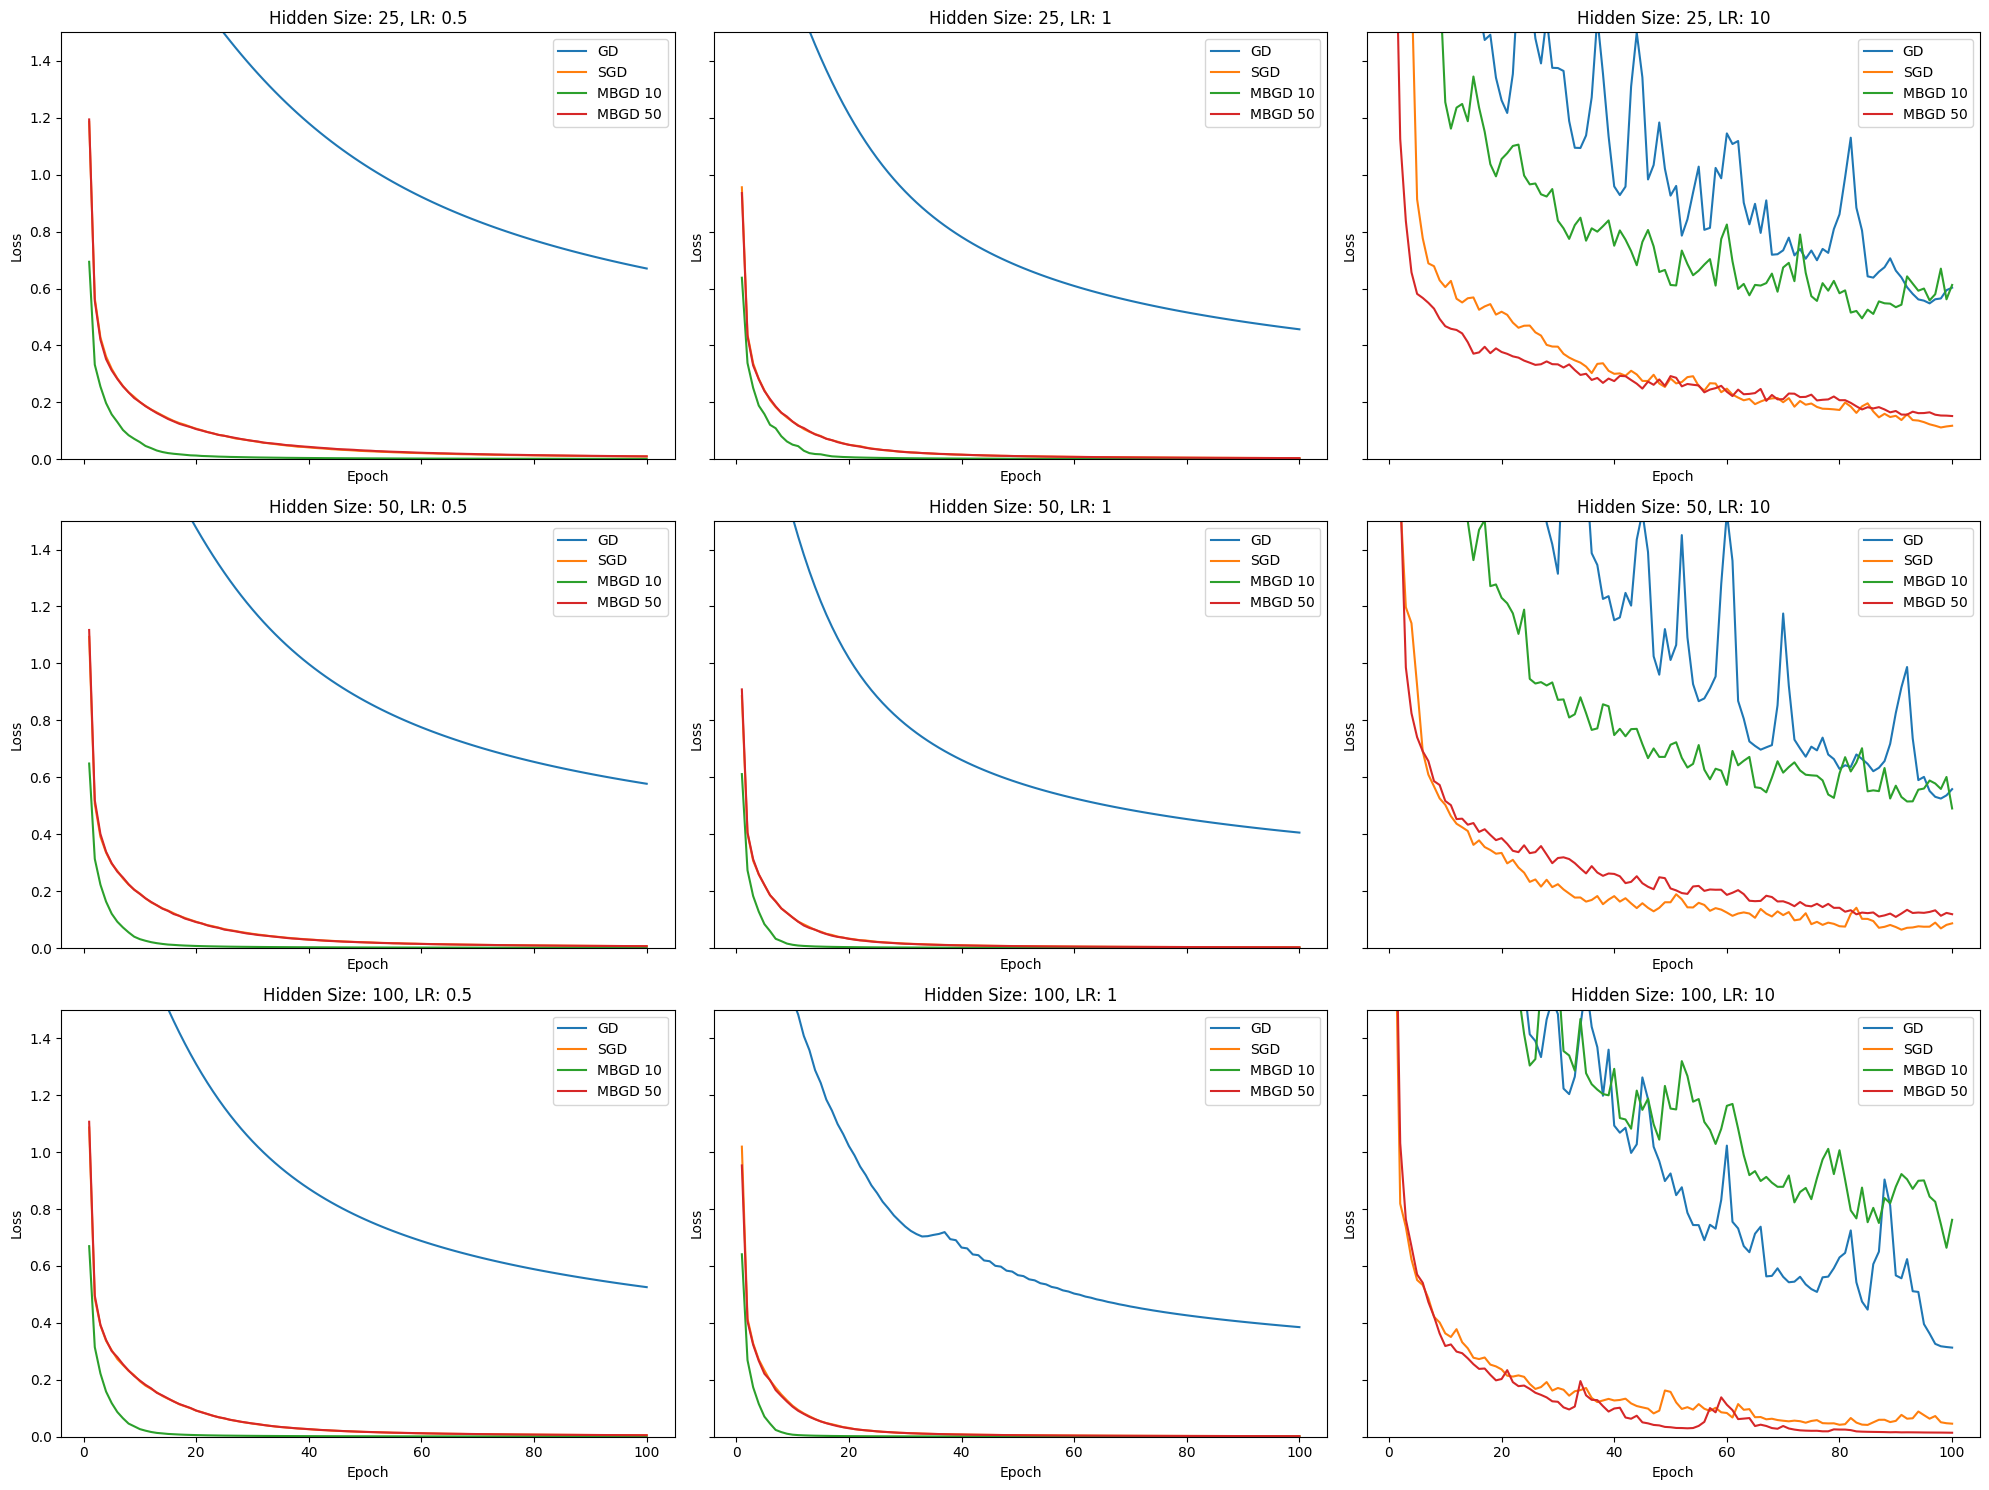

In [41]:
# Plot Results
fig, axs = plt.subplots(len(hidden_sizes), len(learning_rates), figsize=(20, 15), sharex=True, sharey=True)

for i, hidden_size in enumerate(hidden_sizes):
    for j, lr in enumerate(learning_rates):
        ax = axs[i, j]
        for method in ['GD', 'SGD', 'MBGD 10', 'MBGD 50']:
            losses, accuracy, precision, recall, f1 = results[(hidden_size, lr, method)]
            epochs = range(1, num_epochs_gd_sgd_mbgd + 1)
            ax.plot(epochs, losses, label=f'{method}')
        ax.set_title(f'Hidden Size: {hidden_size}, LR: {lr}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_ylim(0, 1.5)
        ax.legend()

plt.tight_layout()
plt.show()

# Conclusão

## Observações Gerais

1. **Eficiência da GPU:** A GPU processa bem grandes lotes, resultando em tempos de execução rápidos para GD e MBGD 50.
2. **Tamanho da Camada Oculta:** Não afeta significativamente o tempo de execução, indicando que a GPU está utilizando seu paralelismo de forma eficiente.
3. **Taxa de Aprendizado Alta (10):** GD é instável, mas SGD e MBGD 10 lidam melhor com a alta taxa, mantendo a perda mais controlada.

## Desempenho dos Métodos

### Gradient Descent (GD)
- **Tempo:** ~6-7s.
- **Desempenho:** Redução suave na perda para LR 0.5 e 1, instável para LR 10.
- **Conclusão:** Eficiente para taxas de aprendizado baixas, menos robusto para taxas altas.

### Stochastic Gradient Descent (SGD)
- **Tempo:** ~16-17s.
- **Desempenho:** Redução rápida na perda com maior variabilidade, estabiliza a perda mesmo para LR 10.
- **Conclusão:** Eficaz, oferece boa generalização e é robusto em diferentes taxas de aprendizado.

### Mini-Batch Gradient Descent com Batch Size 10 (MBGD 10)
- **Tempo:** ~65-70s.
- **Desempenho:** Melhor redução na perda e altos F1-scores, consistente mesmo para LR 10.
- **Conclusão:** Eficaz na redução da perda, mas é o mais lento em termos de tempo de execução e menos robusto para altas taxas.

### Mini-Batch Gradient Descent com Batch Size 50 (MBGD 50)
- **Tempo:** ~16-19s.
- **Desempenho:** Balanceia bem a eficiência do tempo de execução com uma boa redução na perda.
- **Conclusão:** Uma escolha prática, oferecendo bons resultados de perda e precisão com tempos de execução eficientes.

## Resumo das Sugestões

1. **GD:** Melhor para taxas de aprendizado baixas e moderadas.
2. **SGD:** Boa generalização e robusto em diferentes taxas de aprendizado, com maior variabilidade.
3. **MBGD 10:** Maior precisão e redução na perda, mas mais lento.
4. **MBGD 50:** Excelente compromisso entre tempo de execução e desempenho, adequado para várias aplicações.